<a href="https://colab.research.google.com/github/mjdall/seeds_on_a_plate/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
https://www.analyticsvidhya.com/blog/2019/04/introduction-image-segmentation-techniques-python/
MaskR package - https://www.analyticsvidhya.com/blog/2019/07/computer-vision-implementing-mask-r-cnn-image-segmentation/
"""

'\nhttps://www.analyticsvidhya.com/blog/2019/04/introduction-image-segmentation-techniques-python/\nMaskR package - https://www.analyticsvidhya.com/blog/2019/07/computer-vision-implementing-mask-r-cnn-image-segmentation/\n'

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

os.chdir("/content/drive/MyDrive/seeds_on_a_plate/")

In [ ]:
from skimage.color import rgb2gray
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import ndimage

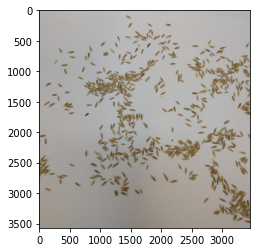

In [ ]:
image = plt.imread("data/cropped/pure request 6.jpg")
image.shape

plt.imshow(image)

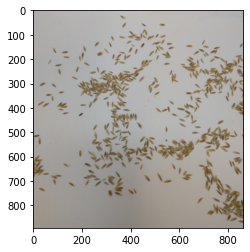

In [ ]:
from skimage.transform import rescale, resize, downscale_local_mean

image_resized = resize(image, (image.shape[0] // 4, image.shape[1] // 4),
                       anti_aliasing=True)

plt.imshow(image_resized)

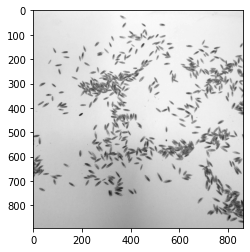

In [ ]:
gray = rgb2gray(image_resized)
plt.imshow(gray, cmap="gray")

In [ ]:
import dask

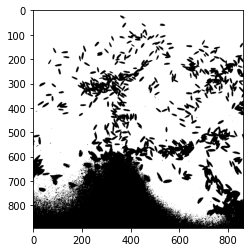

In [ ]:
gray = rgb2gray(image_resized)
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
gray_mean = gray_r.mean()

for i in range(gray_r.shape[0]):
  update_val = 1 if gray_r[i] > .6 else 0
  gray_r[i] = update_val

gray = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray, cmap='gray')

In [ ]:
gray.shape

(892, 863)

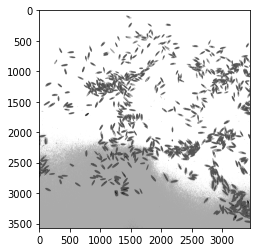

In [ ]:
gray = rgb2gray(image)
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
gray_mean = gray_r.mean()

for i in range(gray_r.shape[0]):
    if gray_r[i] > gray_mean:
        update_val = 3
    elif gray_r[i] > 0.5:
        update_val = 2
    elif gray_r[i] > 0.25:
        update_val = 1
    else:
        update_val = 0
    gray_r[i] = update_val

gray = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray, cmap='gray')

In [ ]:
gray = rgb2gray(image)

# defining the sobel filters
sobel_horizontal = np.array([np.array([1, 2, 1]), np.array([0, 0, 0]), np.array([-1, -2, -1])])
print(sobel_horizontal, 'is a kernel for detecting horizontal edges')
 
sobel_vertical = np.array([np.array([-1, 0, 1]), np.array([-2, 0, 2]), np.array([-1, 0, 1])])
print(sobel_vertical, 'is a kernel for detecting vertical edges')

[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]] is a kernel for detecting horizontal edges
[[-1  0  1]
 [-2  0  2]
 [-1  0  1]] is a kernel for detecting vertical edges


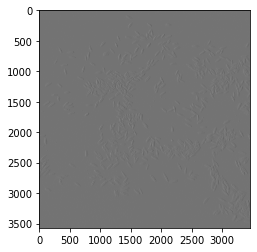

In [ ]:
out_h = ndimage.convolve(gray, sobel_horizontal, mode='reflect')
out_v = ndimage.convolve(gray, sobel_vertical, mode='reflect')

plt.imshow(out_v, cmap='gray')

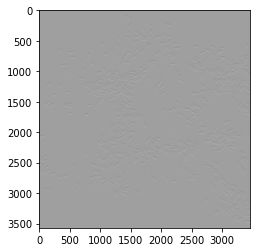

In [ ]:
plt.imshow(out_h, cmap='gray')

In [ ]:
def clamp(v, upper):
  return upper if v > upper else v

In [ ]:
os.makedirs("model", exist_ok=True)

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 830'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


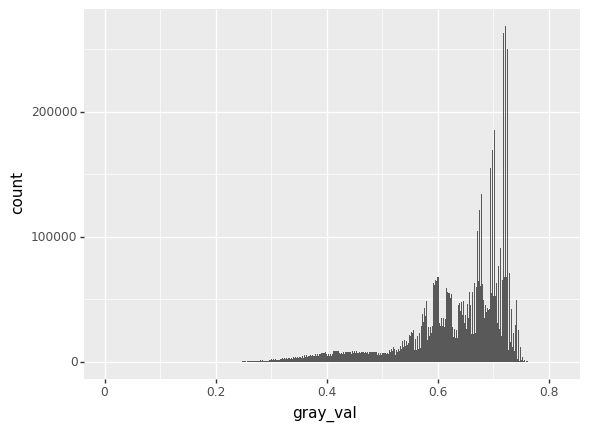

<ggplot: (8765296450725)>

In [ ]:
import plotnine as pn

def get_hex_representation(r, g, b):
  return int("0x%02x%02x%02x" % (r, g, b), 16)

gray = rgb2gray(image)
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])

gray_df = pd.DataFrame({ "gray_val": list(gray_r) })
gray_df["less_than_5"] = gray_df.gray_val <= .7

(
  pn.ggplot(gray_df, pn.aes(x = "gray_val")) +
  pn.geom_histogram()
)

In [ ]:
gray.shape

(3570, 3455)

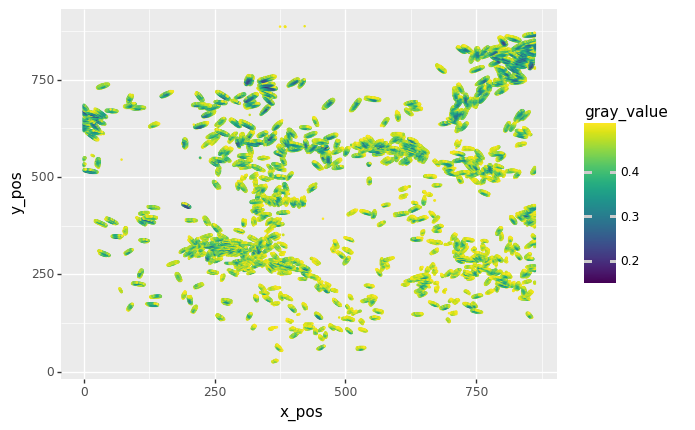

<ggplot: (8765292888997)>

In [ ]:
from plotnine import ggplot, geom_point, theme

gray = rgb2gray(image_resized)
gray_mean = gray.reshape(gray.shape[0]*gray.shape[1]).mean()

x_positions = []
y_positions = []
gray_values = []

for y in range(gray.shape[0]):
  for x in range(gray.shape[1]):
    gray_value = gray[y][x]
    if gray_value <= .5:
      x_positions.append(x)
      y_positions.append(y)
      gray_values.append(gray_value)

active_positions = pd.DataFrame({ "x_pos": x_positions, "y_pos": y_positions, "gray_value": gray_values })

(
  ggplot(active_positions, pn.aes(x = "x_pos", y = "y_pos", colour = "gray_value")) +
  geom_point(size = .01)
)

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 89'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


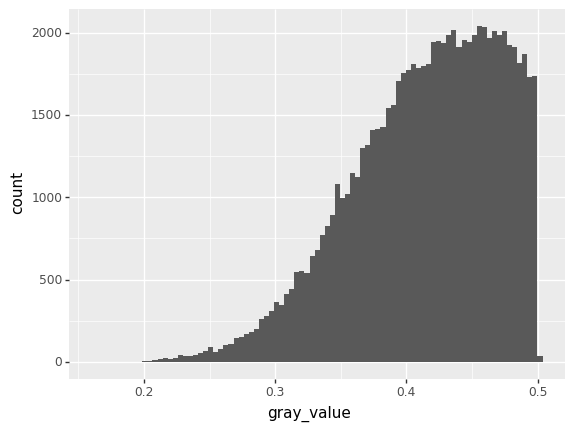

<ggplot: (8765292879461)>

In [ ]:
(
  pn.ggplot(active_positions, pn.aes(x = "gray_value")) +
  pn.geom_histogram()
)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


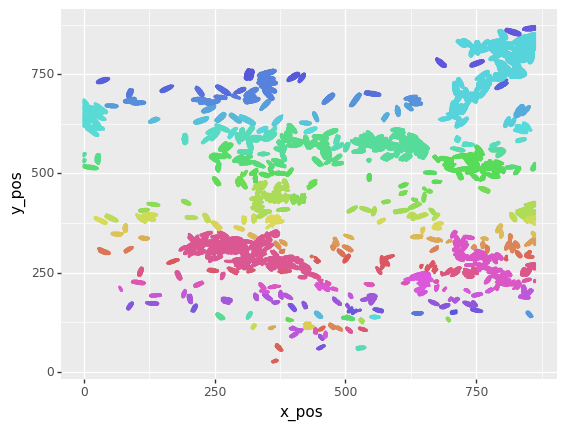

<ggplot: (8765284386277)>

In [ ]:
from sklearn.cluster import DBSCAN

active_positions["cluster"] = DBSCAN(eps=3, min_samples=10).fit_predict(active_positions.loc[:, ["x_pos", "y_pos"]])
active_positions["cluster_fct"] = active_positions.cluster.astype(str)
active_positions_filt = active_positions[active_positions.cluster_fct != "-1"]

(
  ggplot(active_positions_filt, pn.aes(x = "x_pos", y = "y_pos", colour = "cluster_fct")) +
  geom_point(size = .01) +
  theme(legend_position = "none")
)

In [ ]:
bounding_boxes = active_positions_filt.groupby("cluster_fct").agg(
    min_x=("x_pos", "min"),
    max_x=("x_pos", "max"),
    min_y=("y_pos", "min"),
    max_y=("y_pos", "max"),
)

bounding_boxes.reset_index(inplace=True)
bounding_boxes["box_area"] = (bounding_boxes.max_x - bounding_boxes.min_x) * (bounding_boxes.max_y - bounding_boxes.min_y)
bounding_boxes

,cluster_fct,min_x,max_x,min_y,max_y,box_area
0,0,360,370,24,30,60
1,1,367,379,53,69,192
2,10,450,460,104,113,90
3,100,844,859,288,304,240
4,101,434,437,289,292,9
...,...,...,...,...,...,...
249,95,644,647,262,269,21
250,96,160,181,273,283,210
251,97,441,451,275,289,140
252,98,497,508,276,295,209


/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:360: PlotnineWarning: stat_density : Removed 13 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


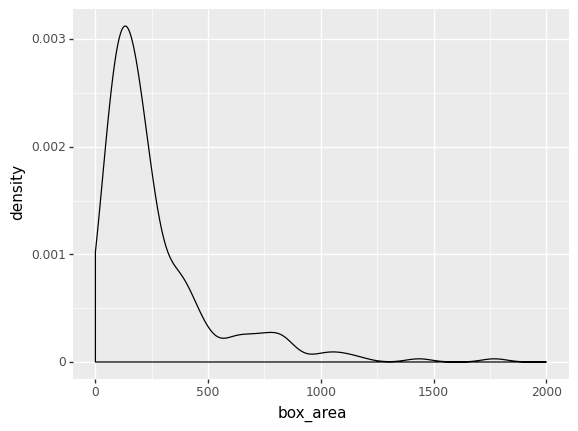

<ggplot: (8765284383521)>

In [ ]:
from plotnine import geom_density, xlim

(
  ggplot(bounding_boxes, pn.aes(x = "box_area")) +
  geom_density() +
  theme(legend_position = "none") +
  xlim(0, 2000)
)

In [ ]:
box_area_90_quant = bounding_boxes.box_area.sort_values(ascending=False).quantile(.98)
box_area_90_quant

11230.47999999999

In [ ]:
mean_box_area = bounding_boxes[bounding_boxes.box_area <= box_area_90_quant].box_area.mean()
print(mean_box_area)

mean_box_area = 750

361.09274193548384


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


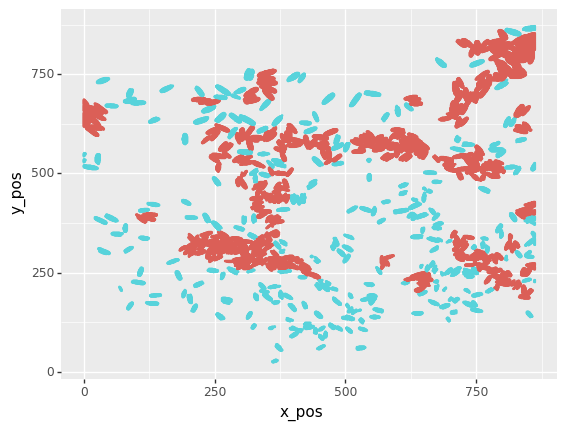

<ggplot: (8765288372473)>

In [ ]:
active_positions_filt["small_filter"] = active_positions_filt.cluster_fct.isin(bounding_boxes[bounding_boxes.box_area <= mean_box_area].cluster_fct)

(
  ggplot(active_positions_filt, pn.aes(x = "x_pos", y = "y_pos", colour = "small_filter")) +
  geom_point(size = .01) +
  theme(legend_position = "none")
)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


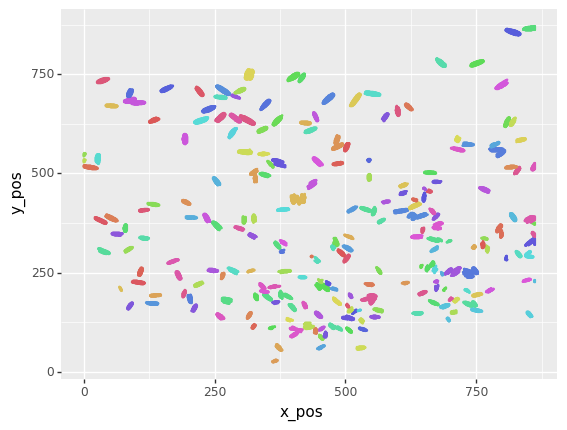

<ggplot: (8765289455921)>

In [ ]:
import random

small_subset = active_positions_filt[active_positions_filt.small_filter]

# resample labels for more distinct colours
cluster_resample = bounding_boxes.copy()
cluster_fct_vals = cluster_resample.cluster_fct.values.tolist()
random.shuffle(cluster_fct_vals)
cluster_resample["cluster_fct2"] = cluster_fct_vals
cluster_resample = cluster_resample.loc[:, ["cluster_fct", "cluster_fct2"]]

small_subset = small_subset.merge(cluster_resample, on="cluster_fct")

(
  ggplot(small_subset, pn.aes(x = "x_pos", y = "y_pos", colour = "cluster_fct2")) +
  geom_point(size = .01) +
  theme(legend_position = "none")
)